# Automatic Crack Segmentation Using Deep Learning

Required libraries

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
import os
from PIL import Image

## Preprocessing Data

Directories containing images and corresponding segmentation masks

In [4]:
TRAIN_IMG_DIR = "train_img/"
TRAIN_MASK_DIR = "train_lab/"
TEST_IMG_DIR = "test_img/"
TEST_MASK_DIR = "test_lab/"

Input images and masks are resized to 256x256 and converted to PyTorch tensors. For masks, Nearest Neighbor interpolation is used to preserve label integrity by copying the exact value of the closest original pixel, preventing the creation of invalid classes.

In [5]:
img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor(),
])

Custom PyTorh dataset for crack segmentation, each sample consists of an RGB image and a binary mask. This dataset enforces paired image–mask consistency, produces binary segmentation targets and returns tensors ready for BCEWithLogitsLoss (Loss function used in neural networks for binary classification problems).

In [ ]:
class DeepCrackDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        # List all image files (.jpg) 
        img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(".jpg")]
        # Create a dictionary of masks indexed by base filename
        mask_files = {os.path.splitext(f)[0]: f for f in os.listdir(mask_dir) if f.lower().endswith(".png")}

        # Match images with their corresponding masks
        self.images = []
        for img in img_files:
            base_name = os.path.splitext(img)[0]
            if base_name in mask_files:
                self.images.append((img, mask_files[base_name]))

        if len(self.images) == 0:
            raise RuntimeError("No JPG/PNG image-mask pairs found")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image and mask
        img_name, mask_name = self.images[idx]

        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Apply transformations
        if self.img_transform:
            image = self.img_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Binarize the mask (foreground vs background)
        mask = (mask > 0.5).float()
        return image, mask

Organization of the images and mask so that the model can read them efficiently during training and evaluation.

In [ ]:
train_ds = DeepCrackDataset(
    TRAIN_IMG_DIR, TRAIN_MASK_DIR,
    img_transform, mask_transform
)

test_ds = DeepCrackDataset(
    TEST_IMG_DIR, TEST_MASK_DIR,
    img_transform, mask_transform
)

# Batch size of 8 for both training and testing data loaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

## UNet Approach

U-Net is an architecture designed for image segmentation, characterized by its U-shaped design. It first compresses the input to capture context and then expands it to recover the original resolution.

In [ ]:
class DoubleConv(nn.Module):
    """
    Fundamental building block of U-Net:
    two consecutive 3x3 convolutions with BatchNorm and ReLU.

    - Two convolutions increase the receptive field without losing spatial resolution. Padding=1 keeps dimensions.
    - BatchNorm helps with training stability and convergence by normalizing data.
    - ReLU introduces non-linearity.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    """
    U-Net architecture for image segmentation.
    """
    def __init__(self):
        super().__init__()

        # Downsampling (encoder) path
        # Each step reduces the spatial dimensions by half while doubling the channels. This leads to better feature extraction by capturing global context.
        self.down1 = DoubleConv(3, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        # The bottleneck captures the most abstract features at the lowest resolution.
        self.middle = DoubleConv(512, 1024)

        # Upsampling (decoder) path
        # Each step increases the spatial resolution by a factor of two and reduces the channel count by half. Recover spatial details lost during pooling using skip connections from the encoder.
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        # Final 1x1 convolution to map to output classes
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool(d1))
        d3 = self.down3(self.pool(d2))
        d4 = self.down4(self.pool(d3))

        m = self.middle(self.pool(d4))

        u4 = self.up4(m)
        u4 = self.conv4(torch.cat([u4, d4], dim=1))

        u3 = self.up3(u4)
        u3 = self.conv3(torch.cat([u3, d3], dim=1))

        u2 = self.up2(u3)
        u2 = self.conv2(torch.cat([u2, d2], dim=1))

        u1 = self.up1(u2)
        u1 = self.conv1(torch.cat([u1, d1], dim=1))

        return self.final(u1)

Definition of "evaluate_model". the function valuates a segmentation model of a given dataset.

Metrics:

- Accuracy: pixel-wise classification accuracy.
- IoU (Jaccard Index): overlap between prediction and ground truth.
- F1-score (Dice coefficient): harmonic mean of precision and recall.

In [ ]:
def evaluate_model(model, loader, device):
    model.eval()
    total_iou, total_f1, total_acc = 0, 0, 0
    num_batches = len(loader)

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            # Sigmoid converts raw logits (unnormalized outputs of the neural network) into probabilities in [0, 1]
            outputs = torch.sigmoid(model(images))
            # Threshold probabilities to obtain binary predictions
            preds = (outputs > 0.5).float()

            # Pixel-wise accuracy
            acc = (preds == masks).float().mean()
            total_acc += acc.item()

            # Intersection over Union (IoU)
            intersection = (preds * masks).sum()
            union = (preds + masks).sum() - intersection

            iou = (intersection + 1e-6) / (union + 1e-6)
            # F1-score (Dice coefficient)
            f1 = (2 * intersection + 1e-6) / (preds.sum() + masks.sum() + 1e-6)

            total_iou += iou.item()
            total_f1 += f1.item()

    print("\n--- Test results ---")
    print(f"Accuracy: {total_acc/num_batches:.4f}")
    print(f"IoU (Jaccard): {total_iou/num_batches:.4f}")
    print(f"F1-Score (Dice): {total_f1/num_batches:.4f}")

## Training

In [ ]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate UNet model and move it to the selected device
model = UNet().to(device)

# Adam optimizer with a low learning rate for stable convergence
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Binary Cross Entropy Loss with class weighting to address class imbalance. Without weighting, the model learns to predict background everywhere, this forces the network to care more about cracks
# pos_weight increases the penalty for misclassified crack pixels
criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([5.0]).to(device)
)


num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Compute loss between logits and ground truth masks
        loss = criterion(outputs, masks)
        # Backpropagation and parameter update
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss/len(train_loader):.4f}")

Epoch [1/10] - Loss: 0.5999
Epoch [2/10] - Loss: 0.4455
Epoch [3/10] - Loss: 0.4141
Epoch [4/10] - Loss: 0.3903
Epoch [5/10] - Loss: 0.3636
Epoch [6/10] - Loss: 0.3516
Epoch [7/10] - Loss: 0.3311
Epoch [8/10] - Loss: 0.3137
Epoch [9/10] - Loss: 0.2941
Epoch [10/10] - Loss: 0.2790


## Final evaluation

In [9]:
evaluate_model(model, test_loader, device)


--- Resultados en Test ---
Accuracy: 0.9817
IoU (Jaccard): 0.6660
F1-Score (Dice): 0.7971


## Results

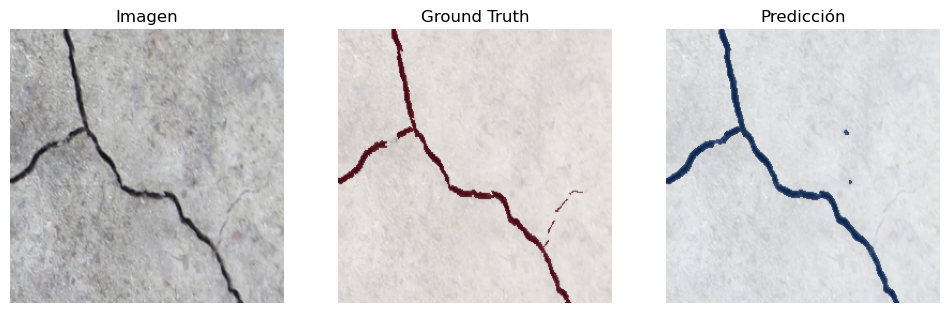

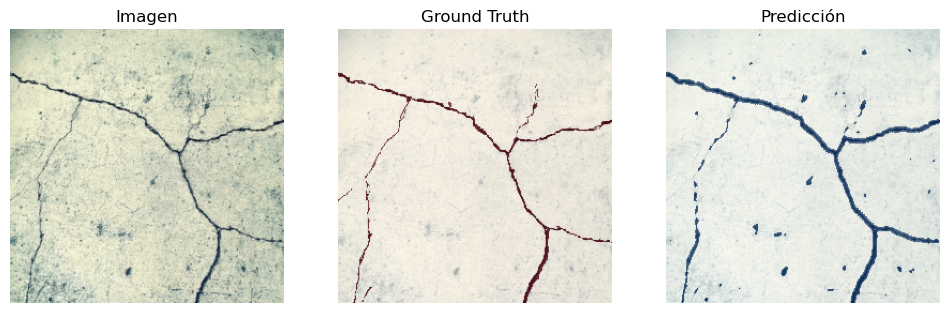

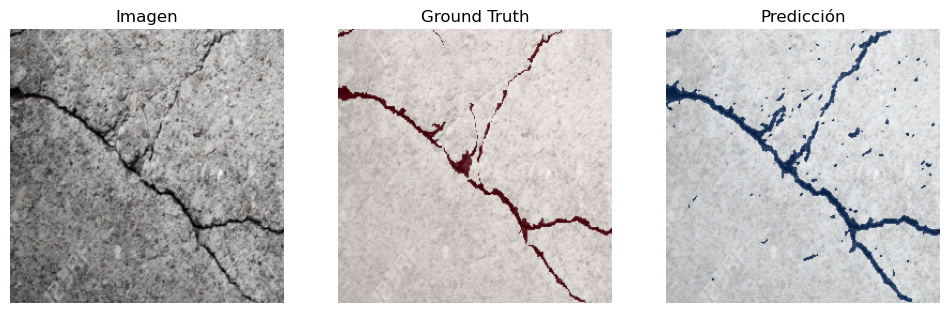

In [10]:
import matplotlib.pyplot as plt

def visualize_overlay(model, dataset, device, idx=0):
    model.eval()

    image, mask = dataset[idx]
    image_in = image.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.sigmoid(model(image_in))
        pred = (pred > 0.5).float()

    img = image.permute(1, 2, 0).numpy()
    gt = mask.squeeze().numpy()
    pr = pred.cpu().squeeze().numpy()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Imagen")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(img)
    plt.imshow(gt, alpha=0.6, cmap="Reds")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(pr, alpha=0.6, cmap="Blues")
    plt.title("Predicción")
    plt.axis("off")

    plt.show()


for i in range(3):
    visualize_overlay(model, test_ds, device, idx=i)

# Tranfer Learning Approach

In [8]:
class FCNResNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        # Load pretrained ResNet50
        resnet = models.resnet50(pretrained=True)

        # Use ResNet layers as encoder
        self.layer0 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )
        self.layer1 = resnet.layer1   # 1/4
        self.layer2 = resnet.layer2   # 1/8
        self.layer3 = resnet.layer3   # 1/16
        self.layer4 = resnet.layer4   # 1/32

        # 1x1 convolution for segmentation
        self.classifier = nn.Conv2d(2048, num_classes, kernel_size=1)

    def forward(self, x):
        input_size = x.shape[2:]

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.classifier(x)

        # Upsample to original image size
        x = F.interpolate(x, size=input_size, mode="bilinear", align_corners=False)

        return x


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = FCNResNet(num_classes=1).to(device)


/Users/hjaviersarmientoy/miniforge3/envs/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hjaviersarmientoy/miniforge3/envs/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
bce = nn.BCEWithLogitsLoss()

def loss_fn(pred, target):
    return bce(pred, target)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [18]:
for epoch in range(10):
    model.train()
    total_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.0591
Epoch 2, Loss: 0.0583
Epoch 3, Loss: 0.0584
Epoch 4, Loss: 0.0579
Epoch 5, Loss: 0.0578
Epoch 6, Loss: 0.0578
Epoch 7, Loss: 0.0576
Epoch 8, Loss: 0.0575
Epoch 9, Loss: 0.0579
Epoch 10, Loss: 0.0579


In [19]:
import segmentation_models_pytorch as smp

model.eval()
with torch.no_grad():
    preds = torch.sigmoid(model(images))
    preds = (preds > 0.5).long()

    masks = masks.long()

    tp, fp, fn, tn = smp.metrics.get_stats(
        preds,
        masks,
        mode="binary"
    )

    iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    f1  = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
    accuracy = smp.metrics.accuracy(
        tp, fp, fn, tn,
        reduction="micro"
    )


In [20]:
iou, f1, accuracy

(tensor(0.3505), tensor(0.5191), tensor(0.9646))

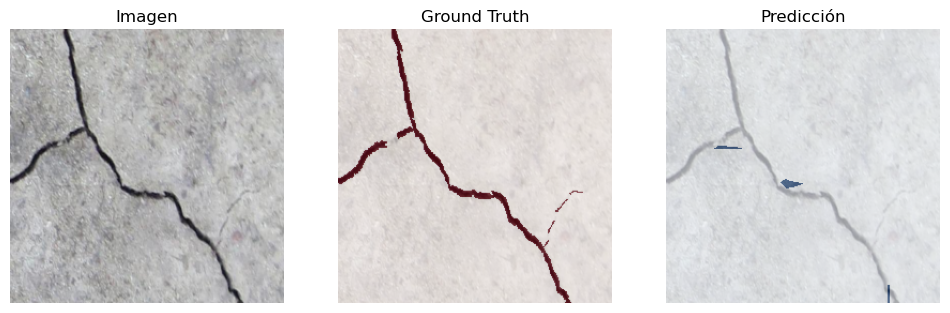

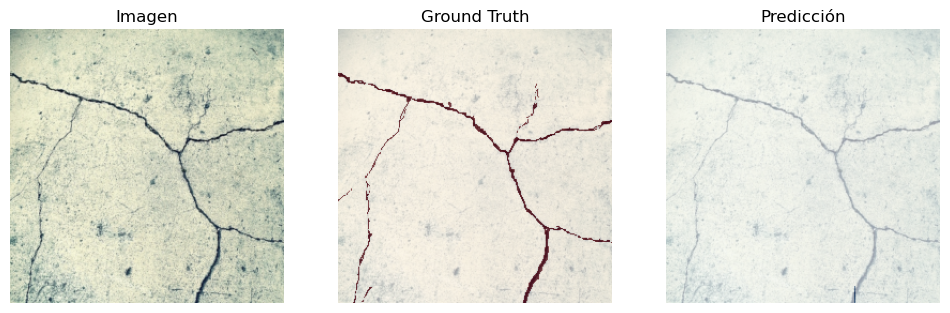

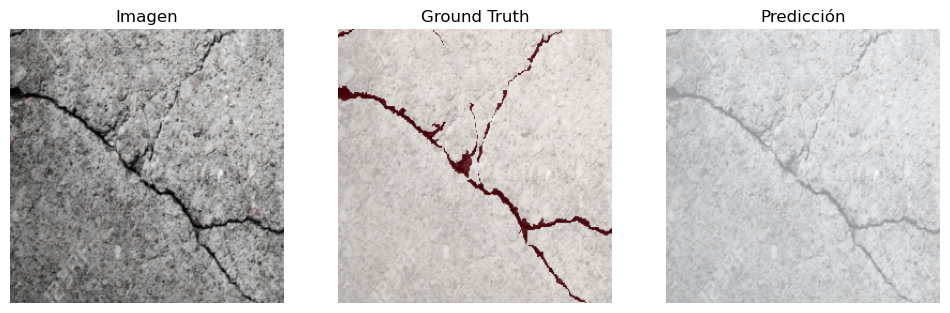

In [22]:
for i in range(3):
    visualize_overlay(model, test_ds, device, idx=i)

In [26]:
class FCN16sResNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        resnet = models.resnet50(pretrained=True)

        # Encoder
        self.layer0 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )
        self.layer1 = resnet.layer1   # 1/4
        self.layer2 = resnet.layer2   # 1/8
        self.layer3 = resnet.layer3   # 1/16
        self.layer4 = resnet.layer4   # 1/32

        # 1×1 convs for skip connections
        self.score_layer4 = nn.Conv2d(2048, num_classes, kernel_size=1)
        self.score_layer3 = nn.Conv2d(1024, num_classes, kernel_size=1)

    def forward(self, x):
        input_size = x.shape[2:]

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)

        x3 = self.layer3(x)   # 1/16
        x4 = self.layer4(x3)  # 1/32

        score4 = self.score_layer4(x4)
        score4 = F.interpolate(
            score4,
            size=x3.shape[2:],  # upsample to 1/16
            mode="bilinear",
            align_corners=False
        )

        score3 = self.score_layer3(x3)

        # Fuse (element-wise sum)
        fused = score4 + score3

        # Final upsampling to input size
        out = F.interpolate(
            fused,
            size=input_size,
            mode="bilinear",
            align_corners=False
        )

        return out


In [27]:
model = FCN16sResNet(num_classes=1).to(device)

/Users/hjaviersarmientoy/miniforge3/envs/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hjaviersarmientoy/miniforge3/envs/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
bce = nn.BCEWithLogitsLoss()
dice = smp.losses.DiceLoss(mode="binary")

def loss_fn(pred, target):
    return bce(pred, target) + dice(pred, target)


In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    total_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        preds = model(images)
        loss = loss_fn(preds, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 1.0101
Epoch 2, Loss: 0.7352
Epoch 3, Loss: 0.6560
Epoch 4, Loss: 0.6011
Epoch 5, Loss: 0.5580
Epoch 6, Loss: 0.5327
Epoch 7, Loss: 0.4968
Epoch 8, Loss: 0.4787
Epoch 9, Loss: 0.4676
Epoch 10, Loss: 0.4594


In [30]:
import segmentation_models_pytorch as smp

model.eval()
with torch.no_grad():
    preds = torch.sigmoid(model(images))
    preds = (preds > 0.5).long()

    masks = masks.long()

    tp, fp, fn, tn = smp.metrics.get_stats(
        preds,
        masks,
        mode="binary"
    )

    iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    f1  = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
    accuracy = smp.metrics.accuracy(
        tp, fp, fn, tn,
        reduction="micro"
    )


In [31]:
iou, f1, accuracy

(tensor(0.6645), tensor(0.7984), tensor(0.9885))

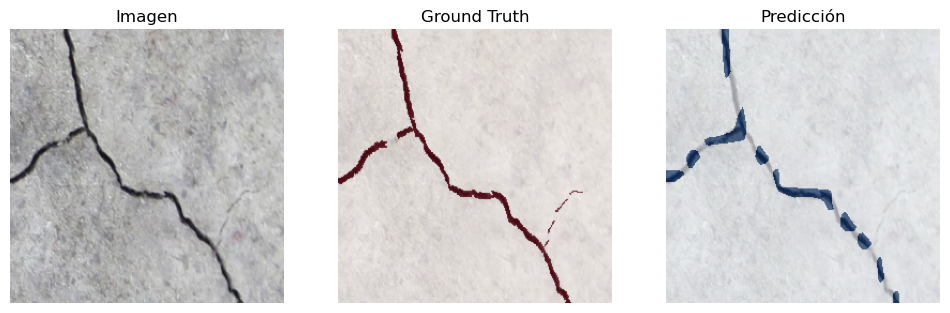

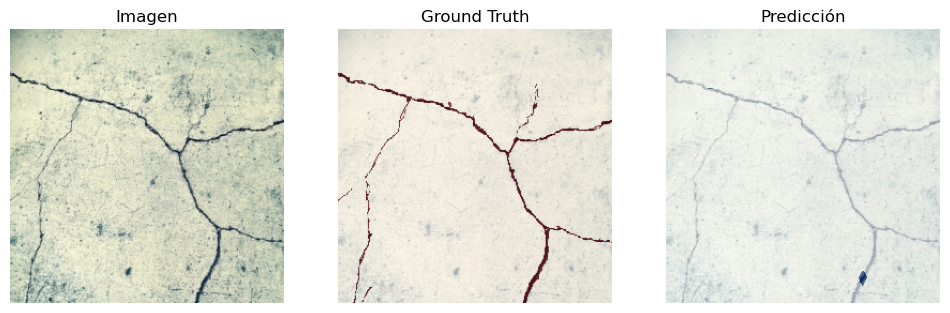

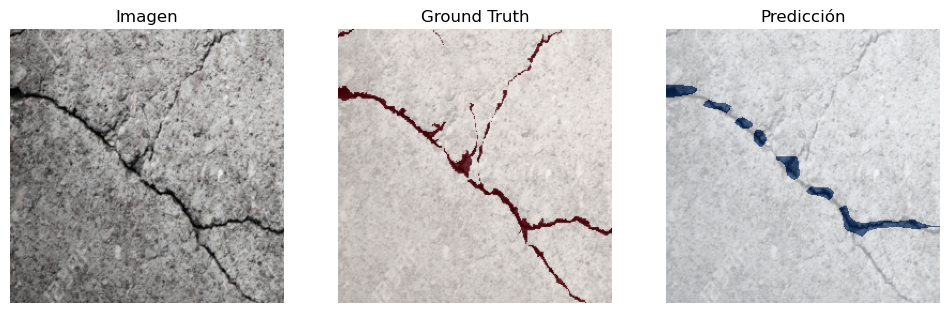

In [32]:
for i in range(3):
    visualize_overlay(model, test_ds, device, idx=i)